<div align="center">
<h1 align="center"><strong>Does size matter?</strong></h1>
  <p align="center">
    Applied Data Analysis (CS-401)
  </p>
</div>

Customers are increasingly relying on **product rating** websites to inform their purchasing decisions. It has been demonstrated that when customers rate a product, they often exhibit a **tendency to be influenced by the previous ratings** of other customers, a phenomenon known as the **_herding effect_**.

Despite this, an unresolved research question revolves around comprehending **how ratings might be impacted by the scale and the reputation of the vendor**. Utilizing data sourced from beer reviews websites, our objective is to investigate the **connection** between the **size and fame of vendors** (specifically, breweries) and **the perceived quality** of their products.

Through the quantification of brewery size and popularity using **predefined metrics** and the **extraction of sentiment** from textual reviews, our aim is to ascertain whether a correlation exists between vendor size and notoriety and perceived product quality. Additionally, we plan to **explore the behaviors** of diverse consumer bases, considering **temporal dimensions** (how these phenomena have evolved over the years and seasons within the same year) and **spatial dimensions** (how these relationships differ across states and countries).


## **BeerAdvocate**: Project proposal and initial analysis

In [1]:
# Import  libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import difflib
import os
from datetime import datetime

In [12]:
# Define the data folder paths for BeerAdvocate
DATA_FOLDER_BA = '../DATA/BeerAdvocate/'

# Define the file paths for the datasets
Beers_DATASET = DATA_FOLDER_BA+"beers.csv"
Users_DATASET = DATA_FOLDER_BA+"users.csv"
Reviews_DATASET = DATA_FOLDER_BA+"reviews_BA.csv"
Breweries_DATASET = DATA_FOLDER_BA+"breweries.csv"

# Dataset exploration & cleaning

The first step of the project consits in exploring the data available in the dataset as well as pre-processing them. This step consists mainly in handling the potential missing data and reformatting what needs to be reformated. The following subsections present this step for every datasets available.

### **Beers**

We starts with the dataset containing information about beers. We will probably not use this datatset since our project focuses more on the reviews and breweries but we decided to still perform some pre-processing on it in the case where we suddenly need it during the analysis of Milestone 3. The dataset includes the following columns:

- `beer_id`: Identifier for the beer.
- `beer_name`: Name of the beer.
- `brewery_id`: Identifier for the brewery producing the beer.
- `brewery_name`: Name of the brewery.
- `style`: Beer style.
- `nbr_ratings`: Number of ratings received.
- `nbr_reviews`: Number of reviews.
- `avg`: Average rating.
- `ba_score`: BeerAdvocate score.
- `bros_score`: Bros score.
- `abv`: Alcohol by volume.
- `avg_computed`: Computed average rating.
- `zscore`: Z-score.
- `nbr_matched_valid_ratings`: Number of matched valid ratings.
- `avg_matched_valid_ratings`: Average of matched valid ratings.


In [14]:
# Read the datasets into Pandas DataFrames
beers = pd.read_csv(Beers_DATASET)
# Display 2 random chosen samples of the set
display(beers)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,Kölsch,3,3,2.71,NaN,NaN,5.0,2.713333,NaN,0,NaN
280819,19140,Nut Brown Ale,885,Summit Station Restaurant & Brewery,English Brown Ale,2,1,3.10,NaN,NaN,5.3,3.250000,NaN,0,NaN
280820,19146,Octoberfest,885,Summit Station Restaurant & Brewery,Märzen / Oktoberfest,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
280821,2805,Scotch Ale,885,Summit Station Restaurant & Brewery,Scotch Ale / Wee Heavy,0,0,NaN,NaN,NaN,7.0,NaN,NaN,0,NaN


We can see that the dataset is composed of 280'823 beers. However, we can see that some data are missing and that some beers have 0 reviews. Furthermore, we should check if there is some duplicates. To address these issues, the following pre-processing steps are applied:

- **Filtering Beers with Less than 5 Reviews**: Deleting beers with fewer than 5 reviews, as they may not be characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the `nbr_ratings` column.

- **Removing Duplicates**: Dropping duplicate entries based on the `beer_name` and `beer_id` columns.

- **Column Selection**: Dropping columns that won't be used in our analysis.

In [15]:
# Set a minimum threshold for the number of reviews
MIN_NUMBER_OF_REVIEWS = 5

# Create a filtered copy of the 'beers' DataFrame with a minimum number of reviews
beers_filt = beers.copy(deep=True)
beers_filt = beers_filt[beers_filt['nbr_reviews'] >= MIN_NUMBER_OF_REVIEWS]

# Remove rows with missing values in the 'nbr_reviews' column
beers_filt = beers_filt[beers_filt['nbr_reviews'].notna()]

# Drop duplicate entries based on the 'beer_name' column
beers_filt = beers_filt.drop_duplicates(subset=['beer_name'])

# Calculate the number of duplicate entries based on 'beer_name' and 'beer_id'
dupli_name = np.sum(beers_filt.duplicated(subset=['beer_name']))
dupli_ID = np.sum(beers_filt.duplicated(subset=['beer_id']))

# Drop specific columns from the filtered DataFrame
beers_filt = beers_filt.drop(['zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'bros_score', 'ba_score'], axis=1)

# Display the filtered DataFrame
display(beers_filt)

# Print the number of duplicate entries for 'beer_name' and 'beer_id'
print(f'Number of duplicate beer name = {dupli_name}')
print(f'Number of duplicate beer ID = {dupli_ID}')


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,abv,avg_computed
25,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,4.8,3.439867
26,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,8,6,3.86,6.0,3.888750
27,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,4.2,3.556094
33,825,Caffrey's Irish Ale,297,Thomas Caffrey Brewing Co.,Irish Red Ale,131,82,3.23,3.8,3.286260
44,16371,Belfast Ale,3415,Whitewater Brewing Co,English Pale Ale,21,13,3.69,4.5,3.666667
...,...,...,...,...,...,...,...,...,...,...
280791,67855,Pivotal Porter (Barrel Aged),23640,Twisted Manzanita Ales,American Porter,19,11,3.28,7.5,3.302105
280796,61815,Riverwalk Blonde,23640,Twisted Manzanita Ales,American Blonde Ale,55,20,3.44,6.0,3.476545
280799,61816,Rustic Horizon Red Ale,23640,Twisted Manzanita Ales,American Amber / Red Ale,40,17,3.34,6.8,3.399000
280807,77211,Where There's Smoke,23640,Twisted Manzanita Ales,Smoked Beer,18,5,3.72,7.4,3.536111


Number of duplicate beer name = 0
Number of duplicate beer ID = 0


After pre-processing, the number of beers drops to 42'923.

### **Users**

We then move to the pre-processing of the dataset containing information about users. The dataset includes the following columns:

- `nbr_ratings`: Number of ratings made.
- `nbr_reviews`: Number of reviews done.
- `user_id`: Unique user identifier.
- `user_name`: User Name.
- `joined`:  Date of the sign up.
- `location`: Location of the User.


In [16]:
# Read the datasets into Pandas DataFrames
users = pd.read_csv(Users_DATASET)
display(users)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


The dataset is composed of 153'704 users. We can again see that some data are missing and that some users did not gave any review. To address these issues our pre-processing involves the following steps:

- **Filtering Users with 0 number of reviews**: Deleting users with 0 reviews, as they are not characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the `nbr_reviews`, `user_id`, `user_name` and `location` columns.

- **Check for Duplicated Users**: Check if there are multiple user with the same id.

- **Formatting the date**: Reformat the date in the column `joined` in UTC format.

In [17]:
# Create a deep copy of the 'users' dataframe
users_filt = users.copy(deep=True)

# Check for duplicates based on user name and user ID
dupli_name = np.sum(users_filt.duplicated(subset=['user_name']))
dupli_ID = np.sum(users_filt.duplicated(subset=['user_id']))

# Remove users with 0 reviews and NaN as the number of reviews
users_filt = users_filt[users_filt['nbr_reviews'] >= 1]
users_filt = users_filt[users_filt['nbr_reviews'].notna()]

# Remove rows with NaN in 'user_id', 'user_name', and 'location'
users_filt = users_filt[users_filt['user_id'].notna()]
users_filt = users_filt[users_filt['user_name'].notna()]
users_filt = users_filt[users_filt['location'].notna()]

# Convert 'joined' column to datetime type
users_filt['joined'] = users_filt['joined'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)

# Rename the 'location' column to 'user_location'
users_filt.rename(columns={'location': 'user_location'}, inplace=True)

# Display the resulting dataframe
display(users_filt)

# Display the number of duplicate user names and user IDs
print(f'Number of duplicate user names = {dupli_name}')
print(f'Number of duplicate user IDs = {dupli_ID}')

# Display the number of NaN values in each category
print('Number of NaN by category:')
print(np.sum(users_filt.isna()))


,nbr_ratings,nbr_reviews,user_id,user_name,joined,user_location
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland
...,...,...,...,...,...,...
153694,1,1,quaffer83.125656,Quaffer83,2007-03-04 11:00:00,"United States, Michigan"
153699,1,1,everman.532342,Everman,2010-11-30 11:00:00,"United States, California"
153700,1,1,justin0001.352175,Justin0001,2009-07-23 10:00:00,"United States, California"
153702,1,1,joetex.800347,JoeTex,2014-05-16 10:00:00,"United States, California"


Number of duplicate user names = 0
Number of duplicate user IDs = 0
Number of NaN by category:
nbr_ratings      0
nbr_reviews      0
user_id          0
user_name        0
joined           0
user_location    0
dtype: int64


After pre-processing, a total of 58'199 users with complete information are kept.

### **Breweries**

Next, we conduct the pre-processing of the dataset containing information about breweries. The dataset comprises the following columns:

- `id`: Brewery identifier.
- `location`: Location of the brewery.
- `name`: Name of the brewery.
- `nbr_beers`: Number of beers produced.


In [18]:
# Read the datasets into Pandas DataFrames
breweries = pd.read_csv(Breweries_DATASET)
display(breweries)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16754,5023,Aruba,Aruba Brewing,0
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491
16756,16186,"United States, North Carolina",Triangle Brewing Company,20


The dataset is composed of 16'758 breweries. We can directly see that some breweries have 0 beers and are therefore not relevant for our analysis. There might be some missing values as well, thus we decided to perform the following pre_processing steps:

- **Filtering Breweries with 0 number of beers**: Deleting breweries with 0 beers, as they are not characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the `nbr_beers`.

- **Removing Duplicates**: Dropping duplicate entries based on the `name` column.

In [19]:
# Create a deep copy of the 'breweries' dataframe
breweries_filt = breweries.copy(deep=True)

# Check for duplicates based on ID
dupli_ID = np.sum(breweries_filt.duplicated(subset=['id']))

# Remove breweries with 0 beers and NaN values
breweries_filt = breweries_filt[breweries_filt['nbr_beers'] >= 1]
breweries_filt = breweries_filt[breweries_filt.notna()]

# Remove duplicate entries based on brewery name
breweries_filt = breweries_filt.drop_duplicates(subset='name')

# Check for duplicates based on name
dupli_name = np.sum(breweries_filt.duplicated(subset=['name']))

# Rename columns for consistency
breweries_filt.rename(columns={'name': 'brewery_name', 'id': 'brewery_id', 'location': 'brewery_location'}, inplace=True)

# Display the resulting dataframe
display(breweries_filt)

# Display the number of duplicate names and IDs
print(f'Number of duplicate names = {dupli_name}')
print(f'Number of duplicate IDs = {dupli_ID}')

# Display the number of NaN values in each category
print('Number of NaN by category:')
print(np.sum(breweries_filt.isna()))


,brewery_id,brewery_location,brewery_name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16748,16233,"United States, California",Farmhouse Brewing Co.,4
16751,1613,"United States, Florida",Panama City Brewery & Cafe,5
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491


Number of duplicate names = 0
Number of duplicate IDs = 0
Number of NaN by category:
brewery_id          0
brewery_location    0
brewery_name        0
nbr_beers           0
dtype: int64


After pre-processing, 14'158 breweries are remaining. 

### **Reviews**

We now delve into the BeerAdvocate Reviews dataset, focusing on reviews of various beers. The dataset contains the following columns:

- `beer_name`: Name of the beer.
- `beer_id`: Identifier for the beer.
- `brewery_name`: Name of the brewery producing the beer.
- `brewery_id`: Identifier for the brewery.
- `style`: Beer style.
- `abv`: Alcohol by volume.
- `date`: Timestamp of the review.
- `user_name`: Username of the reviewer.
- `user_id`: Identifier for the user.
- `appearance`: Rating for the beer's appearance.
- `aroma`: Rating for the beer's aroma.
- `palate`: Rating for the beer's palate.
- `taste`: Rating for the beer's taste.
- `overall`: Overall rating.
- `rating`: Overall user rating.
- `text`: Review text.

Since the .txt file containing the reviews is huge, we first converted it into smaller files that we then regrouped in a .csv file. The code in `split_reviews.py` was used or this purpose.

In [20]:
# Read the Reviews dataset into a pandas DataFrame.
reviews_BA = pd.read_csv(Reviews_DATASET)
display(reviews_BA)

C:\Users\begue\AppData\Local\Temp\ipykernel_13968\2230147237.py:2: DtypeWarning: Columns (5,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_BA = pd.read_csv(Reviews_DATASET)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1207735200,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head..."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1207562400,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A ...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1207476000,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of whit...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1207476000,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,Pours ruby brown with a mahogany heart. Tight...
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1207389600,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589581,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1208426400,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dr...
2589582,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1208426400,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beaut...
2589583,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1208426400,Moxley,moxley.205446,5.0,4.0,4.5,5.0,4.5,4.61,Enjoyed a nice 3-way tasting with fellow BA m...
2589584,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,1208340000,Pleepleus,pleepleus.211613,5.0,3.0,4.5,4.5,4.5,4.17,Enjoyed this Arrogant Bastard with fellow BA ...


Our pre-processing begins with the following initial steps:

- **Converting Timestamps to Datetime**: We start by converting the 'date' column, which contains timestamps, into the datetime format. This conversion enables us to perform time-based analyses more effectively.

- **Handling Missing Values**: We address missing values in the dataset by dropping rows with NaN values. This ensures that our analysis is based on complete and reliable data.

- **Removing Unnecessary Column**: The 'abv' column, representing the alcohol by volume, is not useful for our specific analysis. Consequently, we opt to drop this column to streamline our dataset.

- **Removing White Space before and after Stings**: Some strings columns like `user_name` begin with a white space, which is a problem for merging. Consequently we need to remove them.

In [21]:
# Create a deep copy of the reviews_BA DataFrame to avoid modifying the original DataFrame.
reviews_filt = reviews_BA.copy(deep=True)
# Convert the 'date' column to a datetime format.
# If the 'date' value is not NaN, apply the conversion using utcfromtimestamp.
# If the 'date' value is NaN, leave it unchanged.
reviews_filt['date'] = reviews_filt['date'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)
# Drop rows where the 'text' column has NaN values.
reviews_filt = reviews_filt[reviews_filt['text'].notna()]
# Drop the 'abv' column from the reviews_filt DataFrame.
reviews_filt = reviews_filt.drop(['abv'], axis=1)
# Remove leading and trailing whitespaces (if they exist) from the following columns: 
# user_id, user_name, beer_name, brewery_name, style, and text.
reviews_filt.user_id = reviews_filt.user_id.apply(lambda x: x.strip())
reviews_filt.user_name = reviews_filt.user_name.astype(str).apply(lambda x: x.strip())
reviews_filt.beer_name = reviews_filt.beer_name.apply(lambda x: x.strip())
reviews_filt.brewery_name = reviews_filt.brewery_name.apply(lambda x: x.strip())
reviews_filt['style'] = reviews_filt['style'].apply(lambda x: x.strip())
reviews_filt.text = reviews_filt.text.apply(lambda x: x.strip())
# Display the updated reviews_filt DataFrame.
display(reviews_filt)
# Print the number of NaN values for each column in the reviews_filt DataFrame.
print('Number of NaN by category:')
print(np.sum(reviews_filt.isna()))


,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head...."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of white...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,"Pours ruby brown with a mahogany heart. Tight,..."
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured in..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589581,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dra...
2589582,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beauti...
2589583,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,Moxley,moxley.205446,5.0,4.0,4.5,5.0,4.5,4.61,Enjoyed a nice 3-way tasting with fellow BA me...
2589584,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-16 10:00:00,Pleepleus,pleepleus.211613,5.0,3.0,4.5,4.5,4.5,4.17,Enjoyed this Arrogant Bastard with fellow BA m...


Number of NaN by category:
beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            0
dtype: int64


We now aim to visualize the distribution of the length of the reviews to:

- **Get insight into review length variation**: Visualizing the distribution allows us to understand the range and variability in review lengths. Some reviews may be succinct, while others may be more detailed.

- **Assess data quality**: Analyzing review lengths can also serve as a quality check. Unusually short or long reviews may warrant further investigation to ensure data integrity.


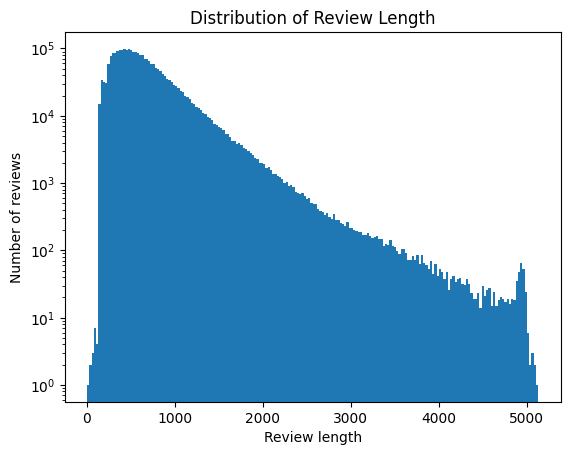

In [22]:
# Create a histogram of the review lengths using the 'text' column from the reviews_filt DataFrame.
plt.hist(reviews_filt['text'].str.len(), bins=200, log=True)

# Set x-axis and y-axis labels and the title.
plt.xlabel('Review length')
plt.ylabel('Number of reviews')
plt.title('Distribution of Review Length')

plt.show()


The BeerAdvocate website advises to create reviews of at list 150 characters. It can be seen that not all the reviews have at least 150 characters. We will therefore remove them in the next steps to keep only relevant revies. The statistics of the review length are displayed in the next cell. As we can see, the median is at 580 characters. The distribution is skewed though, with a small quantity of reviews being more than 5000 characters. This will be interesting to analyse in the next milestone if there is a link between the length of the reviews and the scale or popularity of a brewery.

In [23]:
# Display descriptive statistics of the review lengths.
reviews_filt['text'].str.len().describe()

count    2.589584e+06
mean     6.765771e+02
std      4.082239e+02
min      7.000000e+00
25%      4.030000e+02
50%      5.800000e+02
75%      8.330000e+02
max      5.129000e+03
Name: text, dtype: float64

We attempted to improve consistency by **translating** all non-English textual reviews. To this end, we used the language detection module, $\texttt{detect}$, of the $\texttt{langdetect}$ library to **initially identify the language of each review**.

Due to the considerable computation time required for language detection, we decided to **keep the language identifier** of each review in a separate dataset, together with the **unique identifiers** of the **beer** and the **user**.

This approach allows us to store the language information in our archive, facilitating efficient access without the need to calculate the language detection for each review each time.

Note that if the CSV file containing `user_id`, `beer_id` and `text_lang` (the language identifier of the reviews) exists in the repository, we can avoid recomputing the information. Instead, we can merge the review dataset with this auxiliary dataset into a consolidated dataset, simplifying our analysis process.

In [24]:
# The next sections will need these modules to be run
# Importing the 'unescape' function from the 'html' module for text cleaning of html escape characters
try:
    from html import unescape
except:
    !pip install html

# Importing the 'detect' function from the 'langdetect' module for language detection of reviews
try:
    from langdetect import detect
except:
    !pip install langdetect

# Importing the 'GoogleTranslator' from the 'deep_translatore' module for reviews translation
try:
    from deep_translator import GoogleTranslator
except:
    !pip install deep-translator

In [25]:
# If the .csv file exists then we don't redo the detection
data_name = 'reviews_lang.csv'
CODE_ERROR = 'Error'

if os.path.exists(data_name):
    reviews_language = pd.read_csv(data_name)
    reviews_filt = pd.merge(reviews_filt, reviews_language, on=['beer_id','user_id'], how='left')
else:
    # Detect the language of each review. Handle exception for non corrected reviews.
    text_lang = []
    for review in reviews_filt['text']:
        try:
            text_lang.append(detect(review))
        except:
            text_lang.append(CODE_ERROR)
            continue
    
    # Adding a new column 'text_lang' to store the detected language for each review
    reviews_filt['text_lang'] = pd.Series(text_lang)

    # Store the language information in a  
    reviews_filt[['beer_id', 'user_id', 'text_lang']].to_csv(data_name, index=False)

We can look at the consolidated dataset with the new column giving the language of the review.

In [26]:
# display 3 randomly chosen rows of the new consolidated dataset
display(reviews_filt.sample(3))

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,text_lang
1981912,Oude Kriek De Cam,34122,De Cam Geuzestekerij,2170,Lambic - Fruit,2010-07-26 10:00:00,largadeer,largadeer.99624,4.5,4.5,4.0,4.5,3.0,4.15,"2005 vintage, 750ml bottle.Murky cherry red co...",en
2278960,Milk Stout,81962,Mikkeller ApS,13307,Milk / Sweet Stout,2015-07-04 10:00:00,OmahaKF,omahakf.874957,3.75,4.0,3.5,4.0,4.0,3.94,Pours with a thick head. Smells of roasted ma...,en
1005721,Lot #6 Double IPA,56467,Evolution Craft Brewing Company,19897,American Double / Imperial IPA,2010-02-27 11:00:00,lackenhauser,lackenhauser.1153,4.0,4.5,4.5,5.0,5.0,4.77,Very nice golden orange sort of color. Sticky/...,en


Now we can check if errors occured during the detection, as well as if NaN values appeared in the process.

In [27]:
print('The number of errors detected are:', np.sum(reviews_filt['text_lang'] == CODE_ERROR))

The number of errors detected are: 0


In [28]:
print(f'The number of NaN values in text_lang colum is:', np.sum(reviews_filt['text_lang'].isna()), '/', len(reviews_filt['text_lang']))

The number of NaN values in text_lang colum is: 2 / 2589584


We then decide to drop the NaN values due to the small number of occurrences of NaN values in the `text_lang` column in our filtered reviews dataset.

In [29]:
reviews_filt = reviews_filt[reviews_filt['text_lang'].notna()]

We can now have a look to the variety of languages composing the reviews. As expected a vast majority of them are in English.

In [30]:
print('The count and variety of distinct languages used in the reviews within our dataset:')
print(reviews_filt['text_lang'].value_counts())

The count and variety of distinct languages used in the reviews within our dataset:
text_lang
en       2588992
fr           343
es            62
pt            45
fi            30
af            17
de            13
no            13
nl            10
et             9
ca             7
it             7
da             7
cs             6
so             5
tl             3
sv             2
zh-cn          2
ru             2
ro             1
sq             1
sk             1
id             1
hr             1
tr             1
pl             1
Name: count, dtype: int64


We then filter rows in the DataFrame where the `text_lang` column is not 'en', and then apply translation to English for the corresponding 'text' column.

In [31]:
"""
    Translates the input text to English.

    Parameters:
        text (str): The input text to be translated.
        source (str): The source language (default is 'auto' for automatic detection).
        target (str): The target language (default is 'en' for English).

    Returns:
        The translated text in English.
"""
def translate_to_english(text, source='auto', target='en'):
    translated = GoogleTranslator(source=source, target=target).translate(text)
    return translated

In [32]:
reviews_filt[reviews_filt.text_lang != 'en']['text'] = reviews_filt[reviews_filt.text_lang != 'en']['text'].apply(lambda x: translate_to_english(x))

C:\Users\begue\AppData\Local\Temp\ipykernel_13968\1963095262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_filt[reviews_filt.text_lang != 'en']['text'] = reviews_filt[reviews_filt.text_lang != 'en']['text'].apply(lambda x: translate_to_english(x))


With all reviews now in **English**, we can proceed to remove the `text_lang` column.

In [33]:
reviews_filt = reviews_filt.drop(['text_lang'], axis=1)

We then undertook further pre-processing, focusing on the textual representation of reviews. We followed the following steps:

- **Management of special characters**: After examining the modified and translated dataset, we observed the presence of some special characters such as "\&quot;" and "\x92" in some reviews. To solve this problem, we used the html.unescape function to convert the HTML entities and then removed the non-ASCII characters by encoding them in ASCII and decoding them again.

- **Filtering short reviews**: As a final step, we filtered out reviews with less than 150 characters. This step aimed to exclude shorter reviews from our dataset, focusing on more substantial texts.

In [34]:
# Apply the 'unescape' function to decode HTML entities in the 'text' column
reviews_filt['text'] = reviews_filt['text'].apply(unescape)

# Remove non-ASCII characters by encoding to ASCII and decoding back
reviews_filt['text'] = reviews_filt['text'].apply(lambda x: x.encode('ascii', 'ignore').decode())

# Set the minimum number of characters for reviews
MIN_NUMBER_OF_CHARACTER = 150

# Filter out reviews with fewer than 'min_character' characters
reviews_filt = reviews_filt[reviews_filt['text'].str.len() > MIN_NUMBER_OF_CHARACTER]

In [35]:
display(reviews_filt)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head...."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of white...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,"Pours ruby brown with a mahogany heart. Tight,..."
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured in..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589577,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-21 10:00:00,nasty15108,nasty15108.188801,4.0,4.0,4.0,4.0,4.0,4.00,Poured form a 1pt 6oz bottle into a pint glass...
2589578,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-19 10:00:00,Offa,offa.193015,4.5,4.5,4.0,4.5,4.5,4.45,"This is a nicely strong, slightly rough but de..."
2589579,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dra...
2589580,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beauti...


We end up with 2'587'598 reviews. Now that the datasets are ready, we can start with some preliminary analysis.

## **Metrics Definition**
In our analysis, we introduce **two key metrics** to quantitatively **assess the characteristics of breweries**: Size Metrics and Popularity Metrics. These metrics are created in the next cells. Since we don't have data about the revenue or number of liter produced by the brewery, we decided to base ourself on variable present in the dataset to construct these metrics. Some verification will be done by hand, by searching information about some breweries on the web to assess the quality of the metrics and to correct the coefficients if needed.

####  **Size Metrics**
To numerically evaluate the size of a brewery, we built an index based on the following formula:

$$ \text{Size} = \alpha N_r + \beta N_b + \gamma N_t$$

With:
- $N_r =$ number of reviews normalized by the total number of reviews
- $N_b =$ number of beers produced normalized by the total number of beers
- $N_t =$ number of different types (style) of beer produced normalized by the total number of styles

The coefficients $\alpha, \beta, \gamma$ are chosen by hand. 

#### **Popularity Metrics**
$$ \text{Popularity} = \dfrac{N_r}{N_b}$$

With $N_r =$ number of reviews, $N_b =$ number of beers produced


Note that both metrics are normalized to get a value between 0 and 1.

In [98]:
# Extract brewery_id and style columns from reviews_filt and merge with breweries_filt to get the type of the beer reviewed
review_brew = reviews_filt[['brewery_id', 'style']].copy(deep=True)
review_brew = pd.merge(review_brew, breweries_filt, on=['brewery_id'], how='inner')

# Drop brewery location column from the merged DataFrame as we're not planning to use it
review_brew = review_brew.drop(['brewery_location'], axis=1)

# Count the number of reviews for each brewery
brew_review_count = review_brew.groupby('brewery_id').size().reset_index(name='nbr_reviews')

# Count the number of unique styles for each brewery
brew_style_count = review_brew.groupby('brewery_id')['style'].unique().reset_index(name='styles')
brew_style_count['nbr_styles'] = brew_style_count['styles'].apply(lambda x: len(x))

# Merge the review count, style count, and selected columns from breweries_filt
df_metrics = pd.merge(brew_review_count, brew_style_count[['brewery_id', 'nbr_styles']], on=['brewery_id'], how='inner')
df_metrics = pd.merge(df_metrics, breweries_filt[['brewery_id', 'brewery_name', 'nbr_beers']], on=['brewery_id'], how='inner')
# Remove breweries with less than 8 reviews and les than 2 beers
df_metrics = df_metrics[df_metrics['nbr_reviews'] > 7]
df_metrics = df_metrics[df_metrics['nbr_beers'] > 1]
# Compute size metrics
tot_nb_reviews = df_metrics['nbr_reviews'].sum()
tot_nb_beers = df_metrics['nbr_beers'].sum()
tot_nb_styles = df_metrics['nbr_styles'].sum()
# Choose coeff. aplha, beta, gamma for size metrics
alpha = 5
beta = 2
gamma = 1

# Calculate size metrics based on the weighted sum of reviews, beers, and styles
#df_metrics['size_metrics'] = df_metrics.apply(lambda row: alpha * row['nbr_reviews'] / tot_nb_reviews + beta * row['nbr_beers'] / tot_nb_beers + gamma * row['nbr_styles'] / tot_nb_styles, axis=1)
df_metrics['size_metrics'] = df_metrics.apply(lambda row: alpha * np.log(row['nbr_reviews']) + beta * np.log(row['nbr_beers']) + gamma * np.log(row['nbr_styles']), axis=1)

# Normalize size metrics to ensure values are between 0 and 1
df_metrics['size_metrics'] = df_metrics['size_metrics'] / df_metrics['size_metrics'].max()

# Calculate popularity metrics based on the ratio of reviews to beers
#df_metrics['popularity_metrics'] = df_metrics.apply(lambda row: (row['nbr_reviews'] / tot_nb_reviews) / (row['nbr_beers'] / tot_nb_beers), axis=1)
df_metrics['popularity_metrics'] = df_metrics.apply(lambda row: np.log10(row['nbr_reviews'] / row['nbr_beers']), axis=1)

# Normalize popularity metrics to ensure values are between 0 and 1
df_metrics['popularity_metrics'] = df_metrics['popularity_metrics'] / df_metrics['popularity_metrics'].max()


In [97]:
display(breweries_filt)



,brewery_id,brewery_location,brewery_name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16748,16233,"United States, California",Farmhouse Brewing Co.,4
16751,1613,"United States, Florida",Panama City Brewery & Cafe,5
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491


In [70]:
test.describe()

,brewery_id,nbr_reviews,nbr_styles,nbr_beers,size_metrics,popularity_metrics
count,6372.000000,6372.000000,6372.000000,6372.000000,6.372000e+03,6372.000000
mean,19328.001569,393.107659,12.207941,35.307125,2.269722e-03,0.004730
std,14569.466537,2059.480650,10.367411,52.144093,2.634535e-02,0.021373
min,1.000000,8.000000,1.000000,1.000000,2.550759e-07,0.000048
25%,4074.500000,16.000000,6.000000,10.000000,6.026169e-06,0.000583
50%,18856.000000,37.000000,9.000000,20.000000,2.346698e-05,0.001123
75%,32155.000000,132.000000,15.000000,40.000000,1.426990e-04,0.002857
max,49534.000000,52856.000000,81.000000,981.000000,1.000000e+00,1.000000


Before looking at the metrics, we can have a look to the distribution of the variable used to compute them.

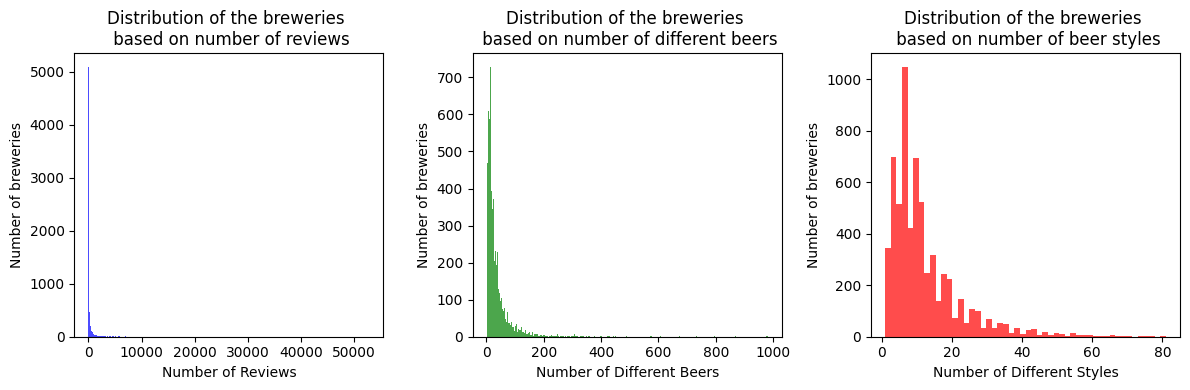

In [74]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram for '# reviews' in the first subplot
axs[0].hist(df_metrics['nbr_reviews'], bins=300, color='blue', alpha=0.7)
axs[0].set_title('Distribution of the breweries \n based on number of reviews')
axs[0].set_xlabel('Number of Reviews')
axs[0].set_ylabel('Number of breweries')

# Plot histogram for '# beers' in the second subplot
axs[1].hist(df_metrics['nbr_beers'], bins=300, color='green', alpha=0.7)
axs[1].set_title('Distribution of the breweries \n based on number of different beers')
axs[1].set_xlabel('Number of Different Beers')
axs[1].set_ylabel('Number of breweries')

# Plot histogram for '# style' in the third subplot
axs[2].hist(df_metrics['nbr_styles'], bins=50, color='red', alpha=0.7)
axs[2].set_title('Distribution of the breweries \n based on number of beer styles')
axs[2].set_xlabel('Number of Different Styles')
axs[2].set_ylabel('Number of breweries')

# Set y-axis scale to logarithmic for better visibility of distribution in all subplots
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
#axs[2].set_yscale('log')

# Adjust layout
plt.tight_layout()

plt.show()

We can see that all the variables have similar distribution. The number of reviews seems to be more skewed though, with a few breweries having a lot more reviews. Note that the y-axis scale is set to **logarithmic** for better visualization of the distribution, and the layout is adjusted for better presentation. We can now have a look to how the breweries are distributed based on the metrics calculated.

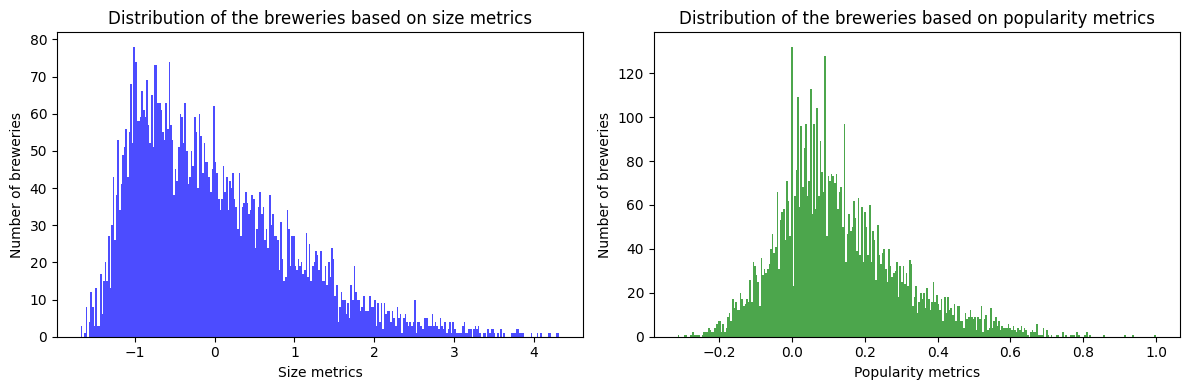

In [99]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram for 'size metrics' in the first subplot
axs[0].hist(df_metrics['size_metrics'], bins=300, color='blue', alpha=0.7)
axs[0].set_title('Distribution of the breweries based on size metrics')
axs[0].set_xlabel('Size metrics')
axs[0].set_ylabel('Number of breweries')

# Plot histogram for 'popularity metrics' in the second subplot
axs[1].hist(df_metrics['popularity_metrics'], bins=300, color='green', alpha=0.7)
axs[1].set_title('Distribution of the breweries based on popularity metrics')
axs[1].set_xlabel('Popularity metrics')
axs[1].set_ylabel('Number of breweries')

# Set y-axis scale to logarithmic for better visibility of distribution in both subplots
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')

# Adjust layout
plt.tight_layout()

plt.show()


In [96]:
display(df_metrics)

,brewery_id,nbr_reviews,nbr_styles,brewery_name,nbr_beers,size_metrics,popularity_metrics
0,1,1620,5,Plzeňský Prazdroj,24,0.632379,0.556822
1,2,40,8,Yellow Rose Brewing Company,9,0.350825,0.197189
2,3,7827,48,Abita Brewing Co.,152,0.827080,0.521040
3,4,11064,26,Allagash Brewing Company,150,0.842440,0.568546
4,5,671,12,Yakima Brewing Co. / Bert Grant's Ales,16,0.571241,0.493904
...,...,...,...,...,...,...,...
11619,48912,19,4,Evans Brewing Co.,13,0.299015,0.050167
11627,48949,35,4,Battery Steele Brewing,5,0.315115,0.257240
11656,49125,24,4,Rock Brothers Brewing,5,0.288555,0.207363
11710,49409,9,5,Bombastic Brewing,12,0.247303,-0.038030


We retrieve the same skew distribution for both metrics. But let's see if the biggest breweries are also the most popular ones.

In [87]:
# Sort breweries by size
size_sorted = df_metrics.sort_values(by='size_metrics', ascending=False).reset_index()
size_sorted.index = np.linspace(1, len(size_sorted), len(size_sorted)).astype(int)
print("Overview of the size metrics ranking:")

# Display a summary of the top breweries based on size metrics
display(size_sorted[['brewery_name', 'size_metrics', 'nbr_reviews', 'nbr_beers', 'nbr_styles']].iloc[[0, 1, 2, 9, 99, 999]])


# Sort breweries by popularity
popu_sorted = df_metrics.sort_values(by='popularity_metrics', ascending=False).reset_index()
popu_sorted.index = np.linspace(1, len(popu_sorted), len(popu_sorted)).astype(int)
print("Overview of the popularity metrics ranking:")

# Display a summary of the top breweries based on popularity metrics
display(popu_sorted[['brewery_name', 'popularity_metrics', 'nbr_reviews', 'nbr_beers']].iloc[[0, 1, 2, 9, 99, 999]])


Overview of the size metrics ranking:


,brewery_name,size_metrics,nbr_reviews,nbr_beers,nbr_styles
1,Sierra Nevada Brewing Co.,1.000000,49895,574,69
2,Stone Brewing,0.997110,46741,671,57
3,Boston Beer Company (Samuel Adams),0.985888,52856,285,77
10,Rogue Ales,0.932310,27767,247,57
100,Port Brewing,0.779628,6944,68,15
1000,Copper Kettle Brewing Company,0.539650,178,83,36


Overview of the popularity metrics ranking:


,brewery_name,popularity_metrics,nbr_reviews,nbr_beers
1,Brasserie d'Orval S.A.,1.000000,2369,2
2,Green Valley Brewing Company (Crooked Creek),0.743164,322,2
3,König-Brauerei GmbH,0.735761,304,2
10,Endurance Brewing Company,0.577671,89,2
100,Brauerei Früh am Dom,0.317986,140,4
1000,Ruby Mountain Brewing,0.162896,67,10


When sorting the breweries by size, it becomes evident that the top-ranking breweries are primarily located in the US. This observation aligns with expectations, considering that the majority of reviewers and breweries are located in the US (as detailed in the following section).

Looking for the 3 biggest and the 100th on the web, we can extract their beer production:

- (1st) Boston Beer Company: 5,300,000 barrels (6,200,000 hL) found under https://en.wikipedia.org/wiki/Boston_Beer_Company
- (2nd) Sierra Nevada Brewing Co.: 1,250,000 barrels (510,000 hL) found under https://en.wikipedia.org/wiki/Sierra_Nevada_Brewing_Company
- (3rd) Stone Brewing: 325,645 barrels (382,000 hL) found under https://en.wikipedia.org/wiki/Stone_Brewing_Co.
- (100th) Uinta Brewing Company: 77'000 barrels found under https://en.wikipedia.org/wiki/Uinta_Brewing_Company

Given these values, it seems that the size metrics works, at least for the top ranked breweries.

On the other side, the popularity metrics yield significantly different results. The top-ranked breweries include historically renowned Belgian breweries such as "Brasserie de Rochefort," notable for its "Trappist" beer, and "Brasserie d'Orval." This highlights that the popularity metric captures a different aspect of brewery influence, focusing on factors beyond sheer size.

It is important to note that this preliminary analysis does not take into account the time evolution. It will be interesting to see how it has evolved over the years. Some breweries for example could have significantly changed size over the years. However this pre-analysis validates the choice of the metrics and opens a large range of possibilities for the next analysis.


## **Geographical Analysis**

The goal of this section is to gain insights into the geographical distribution of both breweries and reviewers within the dataset. Ultimately, we aim to calculate the distances between breweries and their respective reviewers. This analysis could potentially unveil distinctions between brewery types, revealing whether certain types of breweries attract predominantly local reviewers or have a more globally dispersed audience.

### **Analysis of Brewery Location**

We initiate our analysis by examining the geographical distribution of breweries in the dataset. To achieve this, we integrate the dataset with a map sourced from Geopandas (https://www.naturalearthdata.com/downloads/110m-cultural-vectors/).

Ensuring alignment between the country names used in the map and those in the brewery dataset is crucial. To address this, we calculate the Hamming distance between them and substitute the brewery location with the closest match. In instances where no match is found, we opt to eliminate the corresponding brewery. This scenario applies to 26 breweries out of over 14,000, which is deemed acceptable for this level of analysis. It's worth noting that some removed breweries had HTTP links as their location, explaining the lack of match with the map.

For breweries located in the USA, the dataset includes information about the state. Consequently, we extend the same process to the states in the United States of America. To facilitate this, we introduce a new column, 'state,' in the dataframe. This allows us to split the location of US breweries into 'country' and 'state.' 

The geodataframe for the USA can be accessed here: https://eric.clst.org/tech/usgeojson/

In [29]:
# Hamming distance function
def find_closest_match(input_str, target_list):
    """Find the closest match in a list using Hamming distance."""
    return difflib.get_close_matches(input_str, target_list, n=1, cutoff=0.5)

In [30]:
# Make deep copy of breweries filtered dataframe reset indexes (needed for the loop next)
breweries_loc = breweries_filt.copy(deep=True)
breweries_loc.reset_index(inplace=True,drop=True)

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load the USA state map
us_states = gpd.read_file('GeoJSON/gz_2010_us_040_00_500k.json')

# Extract countries name
unique_loc = world['name'].unique()
# Extract state name
unique_state = us_states['NAME'].unique()

# Create column for state in breweries df, will be used for USA
breweries_loc['brewery_state'] = '-'

# Init dropped breweries
dropped_brew = []

# Loop through the 'brewery_location' column and replace values if needed
for i, location in enumerate(breweries_loc['brewery_location']):
    # Check if in USA --> (USA, state)
    try:
        location, state = location.split(', ')
    except:
        state = location  # if not in USA, state = location
    
    # Find closest match with Hamming distance
    closest_match_country = find_closest_match(location, unique_loc)
    
    if closest_match_country:
        # If closest match is USA --> match state      
        if closest_match_country[0] == 'United States of America':
            breweries_loc.at[i, 'brewery_location'] = closest_match_country[0]
            
            # Find state
            closest_match_state = find_closest_match(state, unique_state)
            if closest_match_state:
                breweries_loc.at[i, 'brewery_state'] = closest_match_state[0]
            else:
                breweries_loc = breweries_loc.drop(index=i)
        else:
            # If not in USA --> state = location 
            breweries_loc.at[i, 'brewery_location'] = closest_match_country[0]
            breweries_loc.at[i, 'brewery_state'] = closest_match_country[0]
    else:
        #print(i)
        #print(breweries_loc.at[i, 'brewery_location'])
        # If no match, drop
        dropped_brew.append(location)
        breweries_loc = breweries_loc.drop(index=i)

# Display a sample of the modified dataframe
display(breweries_loc.sample(3))

# Print the number of dropped breweries and their locations
print(f'{len(dropped_brew)} breweries were dropped, at the following location:')
print(dropped_brew)


/var/folders/ds/rx4j_svs5vq2wmr9nxmhsndr0000gn/T/ipykernel_83484/1789466630.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,brewery_id,brewery_location,brewery_name,nbr_beers,brewery_state
12567,39623,Belgium,ASBL Notios,1,Belgium
4618,32651,Australia,Granite Belt Brewery,6,Australia
7174,19402,United States of America,Inland Empire Brewing Company,26,California


28 breweries were dropped, at the following location:
['Turks and Caicos Islands', 'Sao Tome and Principe', 'Virgin Islands (British)', 'Ivory Coast', 'Ivory Coast', 'Seychelles', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Saint Vincent and The Grenadines', 'Mayotte', 'Antigua & Barbuda', 'Liechtenstein', 'Liechtenstein', 'United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com', 'United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bjsrestaurants.com" target="_blank">bjsrestaurants.com', 'United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://capcitybrew.com" target="_blank">capcitybrew.com', 'Un

We explore the **Top 10 countries** with the **highest number of breweries** to gain insights into the **global distribution of brewing establishments**.

In [31]:
# Count the number of breweries in each country
brewery_counts = breweries_loc['brewery_location'].value_counts().reset_index()
brewery_counts.columns = ['brewery_location', 'nb_breweries']

# Identify the top 10 countries
top10 = brewery_counts.sort_values(by='nb_breweries', ascending=False).head(10)
top10 = top10[['brewery_location', 'nb_breweries']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_breweries = top10.nb_breweries.astype(int)

# Display the Top 10 countries with the most breweries
print('Top 10 countries with the most breweries:')
display(top10)

Top 10 countries with the most breweries:


,brewery_location,nb_breweries
1,United States of America,6524
2,Germany,953
3,Finland,934
4,Canada,777
5,Australia,342
6,Belgium,319
7,France,317
8,Italy,309
9,Spain,278
10,Poland,229


As evident from the data, **there are significantly more breweries in the US** compared to other countries. Due to this notable concentration, we will consider the breweries by states in the next section. To facilitate this, we extend the world geodataframe by incorporating the US state geodataframe in the next section.

In [32]:
# Add US states to world df
us_states.rename(columns={'NAME': 'name'}, inplace = True)
world_with_US_states = pd.concat([world[['name','geometry']],us_states[['name','geometry']]])

Let's look again to the Top 10 countries with the highest number of breweries. However, this time, we'll consider **each US state as a distinct 'country'.** Additionally, we'll **visualize the global distribution of breweries** to gain a comprehensive understanding of their geographical spread.

Top 10 countries (considering US states) with the most breweries:


,name,nb_breweries
1,Germany,953
2,Finland,934
3,California,823
4,Canada,777
5,New York,368
6,Washington,357
7,Colorado,351
8,Australia,342
9,Belgium,319
10,France,317


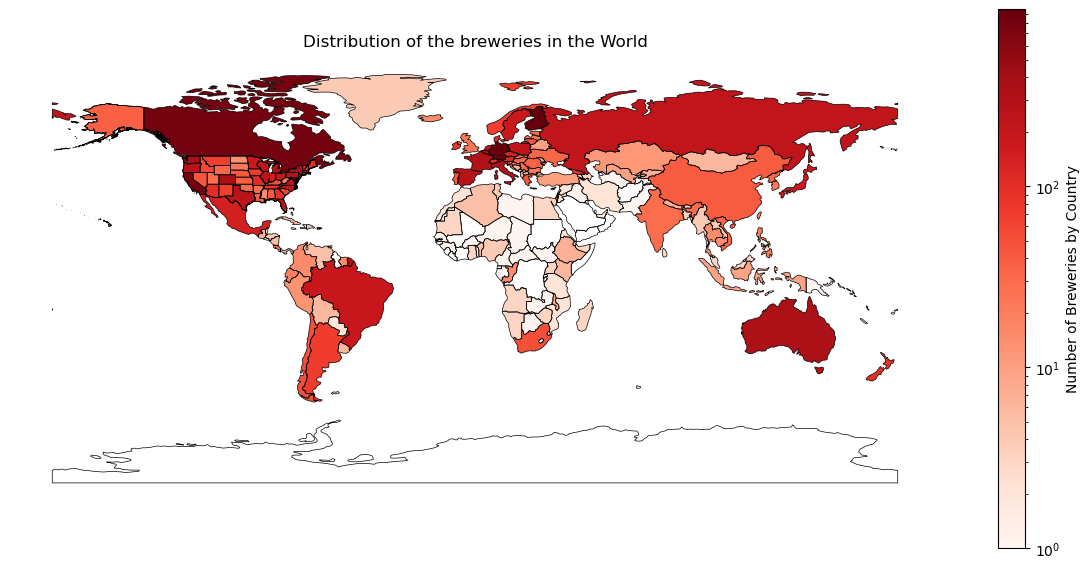

In [33]:
# Count the number of breweries in each country
brewery_counts = breweries_loc['brewery_state'].value_counts().reset_index()
brewery_counts.columns = ['brewery_state', 'nb_breweries']

# Merge brewery counts with the world map data
world_merge = world_with_US_states.merge(brewery_counts, how='left', left_on='name', right_on='brewery_state')

# Fill NaN values (countries without breweries) with 0
world_merge['nb_breweries'].fillna(0, inplace=True)
# Fill NaN values of state with Unknown
world_merge['brewery_state'].fillna('Unknown', inplace=True)

# Find top 10 countries
top10 = world_merge.sort_values(by='nb_breweries', ascending=False).head(10)
top10 = top10[['name', 'nb_breweries']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_breweries = top10.nb_breweries.astype(int)

# Display the Top 10 countries (considering US states) with the most breweries
print('Top 10 countries (considering US states) with the most breweries:')
display(top10)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
world_merge.boundary.plot(ax=ax, color='black', linewidth=0.5)
world_merge.plot(column='nb_breweries', ax=ax, legend=True,
                 norm=LogNorm(vmin=1, vmax=world_merge['nb_breweries'].max()),
                 legend_kwds={'label': "Number of Breweries by Country",
                              'orientation': "vertical"},
                 cmap='Reds')

# Remove the axis
ax.set_title('Distribution of the breweries in the World')
ax.set_axis_off()
plt.show()


The revised analysis reveals distinct results. Germany takes the lead, followed by Finland, and several US states are now present in the Top 10. The conclusion of this analysis is that there are many more breweries in the US than anywhere else in the world. Acknowledging this, it becomes essential to consider the US's internal diversity in subsequent analyses. Given the availability of information about individual US states, incorporating them into the analysis could provide valuable insights, offering a more nuanced understanding of the brewing landscape within the country.

### **Analysis of User Location**
Now that we have gained insights into the distribution of breweries worldwide, we can apply a **similar analysis** to the **user data**. The aim of this analysis is to see whether or not a geographical similarity can be observed between the distribution of breweries and the distribution of users who give reviews. Once again, a matching process based on Hamming's distance must be performed to match the names of the different places.

In [34]:
# Create a copy of the filtered users dataset and reset indexes (needed for the loop next)
users_loc = users_filt.copy(deep=True)
users_loc.reset_index(inplace=True,drop=True)
# Create a column for the state in the users dataframe, to be used for USA
users_loc['user_state'] = '-'

# Initialize a list for dropped user locations
dropped_user = []

# Loop through the 'user_location' column and replace values if needed
for i, location in enumerate(users_loc['user_location']):
    try:
        location, state = location.split(', ')
    except:
        state = location
    
    # Find the closest match using Hamming distance
    closest_match_country = find_closest_match(location, unique_loc)

    # If there is a match
    if closest_match_country:
        if closest_match_country[0] == 'United States of America':
            users_loc.at[i, 'user_location'] = closest_match_country[0]
            
            # Find the state
            closest_match_state = find_closest_match(state, unique_state)
            if closest_match_state:
                users_loc.at[i, 'user_state'] = closest_match_state[0]
            else:
                users_loc = users_loc.drop(index=i)
        else:
            # Replace the value in the DataFrame
            users_loc.at[i, 'user_location'] = closest_match_country[0]
            users_loc.at[i, 'user_state'] = closest_match_country[0]
    # No match, drop the row
    else:
        dropped_user.append(location)
        users_loc = users_loc.drop(index=i)

# Display a sample of the modified users dataframe
display(users_loc.sample(3))

# Print the number of dropped users and their locations
print(f'{len(dropped_user)} users were dropped, at the following location:')
print(dropped_user)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,user_location,user_state
33247,4,4,rmatson.419283,rmatson,2010-01-24 11:00:00,United States of America,Utah
27853,3,3,sipzzz.776454,Sipzzz,2014-01-16 11:00:00,United States of America,Ohio
42814,1,1,bkmurph.218540,bkmurph,2008-05-10 10:00:00,United States of America,Washington


6 users were dropped, at the following location:
['Svalbard and Jan Mayen Islands', 'Isle of Man', 'Svalbard and Jan Mayen Islands', 'Isle of Man', 'South Georgia and South Sandwich Islands', 'British Indian Ocean Territory']


Let's examine the **Top 10 countries** with the **highest number of reviewers** to gain insights into the global distribution of reviewers.

In [35]:
# Count the number of reviewers in each country
reviewers_counts = users_loc['user_location'].value_counts().reset_index()
reviewers_counts.columns = ['user_location', 'nb_reviewers']

# Identify the top 10 countries according to the number of reviewers
top10 = reviewers_counts.sort_values(by='nb_reviewers', ascending=False).head(10)
top10 = top10[['user_location', 'nb_reviewers']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_reviewers = top10.nb_reviewers.astype(int)

# Display the Top 10 countries with the most reviewers
print('Top 10 countries with the most reviewers:')
display(top10)

Top 10 countries with the most reviewers:


,user_location,nb_reviewers
1,United States of America,53879
2,Canada,1798
3,Finland,432
4,Australia,328
5,Germany,190
6,Sweden,141
7,Netherlands,101
8,Belgium,100
9,Ireland,78
10,Mexico,78


As observed, there is once again a **substantial number of reviewers in the US**. The distribution seems fairly similar to that observed for breweries. In the next section, we will **replicate the analysis**, this time considering reviewers based on **US states**.

Top 10 countries (considering US states) with the most reviewers:


,name,nb_reviewers
1,California,5897
2,Pennsylvania,3942
3,New York,3529
4,Illinois,3123
5,Massachusetts,3104
6,Texas,2626
7,Florida,2209
8,Ohio,2185
9,Michigan,2018
10,Canada,1798


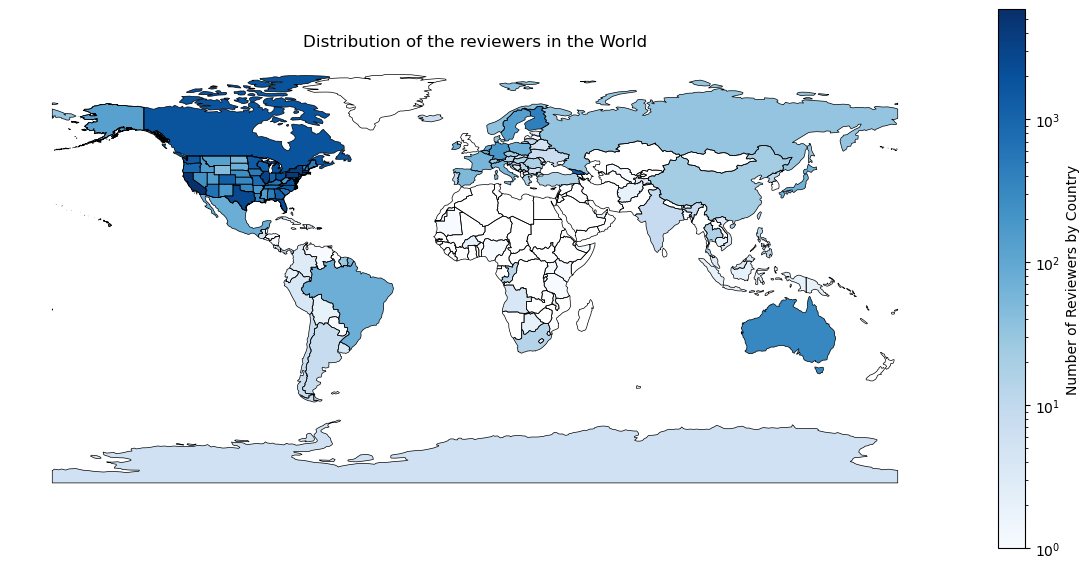

In [36]:
# Count the number of reviewers in each country
reviewers_counts = users_loc['user_state'].value_counts().reset_index()
reviewers_counts.columns = ['user_state', 'nb_reviewers']

# Merge reviewer counts with the world map data
world_merge = world_with_US_states.merge(reviewers_counts, how='left', left_on='name', right_on='user_state')

# Fill NaN values (countries without reviewers) with 0
world_merge['nb_reviewers'].fillna(0, inplace=True)
world_merge['user_state'].fillna('Unknown', inplace=True)

# Identify the top 10 countries
top10 = world_merge.sort_values(by='nb_reviewers', ascending=False).head(10)
top10 = top10[['name', 'nb_reviewers']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_reviewers = top10.nb_reviewers.astype(int)

# Display the Top 10 countries (considering US states) with the most reviewers
print('Top 10 countries (considering US states) with the most reviewers:')
display(top10)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
world_merge.boundary.plot(ax=ax, color='black', linewidth=0.5)
world_merge.plot(column='nb_reviewers', ax=ax, legend=True,
                 norm=LogNorm(vmin=1, vmax=world_merge['nb_reviewers'].max()),
                 legend_kwds={'label': "Number of Reviewers by Country", 'orientation': "vertical"},
                 cmap='Blues')

# Remove the axis
ax.set_title('Distribution of the reviewers in the World')
ax.set_axis_off()
plt.show()


We can see that **the majority of reviewers are concentrated in the USA**. In fact, not only the majority of breweries but also the vast majority of reviewers are located in the USA. This is certainly a crucial factor to take into account in future analyses.

### **Relative distance between Reviewers and Breweries**

Now that we have examined the geographical distribution of breweries and reviewers, our next focus is to **explore the relative distance between the reviewer and the brewery for each review**. This analysis aims to provide insights into **how the popularity of a brewery is distributed globally**.

To achieve this, we begin by calculating the centroid of each country (or state in the case of US). Subsequently, we add these centroid values to both the users and breweries dataframes

In [37]:
# Add centroid to world dataset
world_df = world_with_US_states.copy(deep=True)
world_df['centroids'] = world_df['geometry'].centroid.to_crs(32633)
world_df = world_df.set_index('name')
display(world_df)

/var/folders/ds/rx4j_svs5vq2wmr9nxmhsndr0000gn/T/ipykernel_83484/1780803471.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_df['centroids'] = world_df['geometry'].centroid.to_crs(32633)


,geometry,centroids
name,,
Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",POINT (3951614.713 -17780425.620)
Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",POINT (2728808.700 -734880.629)
W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",POINT (-2323549.058 2976334.742)
Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",POINT (-2512041.055 11343293.680)
United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",POINT (-3479492.330 13425540.869)
...,...,...
South Dakota,"POLYGON ((-96.44341 42.48949, -96.45971 42.486...",POINT (-4404996.539 12614248.332)
Vermont,"POLYGON ((-72.04008 44.15575, -72.04271 44.152...",POINT (-5263344.593 9729638.381)
Virginia,"MULTIPOLYGON (((-76.04653 37.95359, -76.04169 ...",POINT (-6355315.594 10546530.938)


In [38]:
# Create a dataframe of users and breweries with centroids

# Merge breweries with state centroids
brew_cen = pd.merge(breweries_loc, world_df, left_on=['brewery_state'], right_on=['name'], how='inner')
brew_cen.rename(columns={'centroids': 'brewery_centroid'}, inplace=True)

# Merge breweries with country centroids
brew_cen = pd.merge(brew_cen, world_df, left_on=['brewery_location'], right_on=['name'], how='inner')
brew_cen.rename(columns={'centroids': 'brewery_centroid_country'}, inplace=True)

# Drop unnecessary columns
brew_cen = brew_cen.drop(['geometry_x', 'geometry_y', 'nbr_beers', 'brewery_name'], axis=1)

# Merge users with state centroids
user_cen = pd.merge(users_loc, world_df, left_on=['user_state'], right_on=['name'], how='inner')
user_cen.rename(columns={'centroids': 'user_centroid'}, inplace=True)

# Merge users with country centroids
user_cen = pd.merge(user_cen, world_df, left_on=['user_location'], right_on=['name'], how='inner')
user_cen.rename(columns={'centroids': 'user_centroid_country'}, inplace=True)

# Drop unnecessary columns
user_cen = user_cen.drop(['geometry_x', 'geometry_y', 'nbr_ratings', 'nbr_reviews', 'user_name', 'joined'], axis=1)

# Display a sample of the resulting dataframes
display(user_cen.sample(3))
display(brew_cen.sample(3))


,user_id,user_location,user_state,user_centroid,user_centroid_country
22108,frankj1982.26786,United States of America,Massachusetts,POINT (-5550336.124 9606390.495),POINT (-3479492.330 13425540.869)
43467,ahommell.739819,United States of America,Mississippi,POINT (-6752553.393 12381301.364),POINT (-3479492.330 13425540.869)
17662,bloody_roddy.695200,United States of America,Wisconsin,POINT (-4879523.718 11633856.888),POINT (-3479492.330 13425540.869)


,brewery_id,brewery_location,brewery_state,brewery_centroid,brewery_centroid_country
4391,26950,United States of America,Pennsylvania,POINT (-5783356.733 10357007.180),POINT (-3479492.330 13425540.869)
11779,30029,Australia,Australia,POINT (7236580.565 -15064696.802),POINT (7236580.565 -15064696.802)
10899,19654,Turkey,Turkey,POINT (2247169.158 4522198.641),POINT (2247169.158 4522198.641)


In [39]:
# Merge with reviews
review_brew_user = reviews_filt[['brewery_id','user_id']].copy(deep=True)
review_brew_user = pd.merge(review_brew_user,brew_cen,on=['brewery_id'],how='inner')
review_brew_user = pd.merge(review_brew_user,user_cen,on=['user_id'],how='inner')
display(review_brew_user.sample(3))

,brewery_id,user_id,brewery_location,brewery_state,brewery_centroid,brewery_centroid_country,user_location,user_state,user_centroid,user_centroid_country
1076101,16057,bbothen.96204,United States of America,Hawaii,POINT (-402426.038 17731731.921),POINT (-3479492.330 13425540.869),United States of America,California,POINT (-3602740.478 14755496.679),POINT (-3479492.330 13425540.869)
2184861,98,raszputini.579433,United States of America,Massachusetts,POINT (-5550336.124 9606390.495),POINT (-3479492.330 13425540.869),United States of America,North Carolina,POINT (-6708224.057 10671163.866),POINT (-3479492.330 13425540.869)
1871924,394,adamks.178937,United States of America,Pennsylvania,POINT (-5783356.733 10357007.180),POINT (-3479492.330 13425540.869),United States of America,Washington,POINT (-2799266.018 13704003.390),POINT (-3479492.330 13425540.869)


Now that we have a dataframe containing every review, along with the centroid of the reviewed brewery and the centroid of the user's residence, we can proceed to **compute the distance between the reviewer and the brewery**.

In [40]:
rev_distance = review_brew_user.copy(deep=True)
rev_distance['distance_state'] = rev_distance.apply(lambda row: row['brewery_centroid'].distance(row['user_centroid'])/1000, axis=1)

rev_distance['distance_country'] = rev_distance.apply(lambda row: row['brewery_centroid_country'].distance(row['user_centroid_country'])/1000, axis=1)

display(rev_distance.sample(10))
#rev_distance['distance'].describe()

/Users/tomfahndrich/opt/anaconda3/envs/ada/lib/python3.9/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/tomfahndrich/opt/anaconda3/envs/ada/lib/python3.9/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


,brewery_id,user_id,brewery_location,brewery_state,brewery_centroid,brewery_centroid_country,user_location,user_state,user_centroid,user_centroid_country,distance_state,distance_country
1673424,203,realale.594,Finland,Finland,POINT (1036316.080 7200760.511),POINT (1036316.080 7200760.511),United States of America,Missouri,POINT (-5675940.689 12307455.517),POINT (-3479492.330 13425540.869),8434.021865,7690.280626
1784454,1199,thecarster1.313201,United States of America,Michigan,POINT (-5075723.634 11166153.626),POINT (-3479492.330 13425540.869),United States of America,Pennsylvania,POINT (-5783356.733 10357007.180),POINT (-3479492.330 13425540.869),1074.924450,0.000000
2368359,302,lwg1970.447479,United States of America,New York,POINT (-5453688.465 10057959.632),POINT (-3479492.330 13425540.869),United States of America,Ohio,POINT (-5790180.691 11007539.976),POINT (-3479492.330 13425540.869),1007.437267,0.000000
1216203,368,derek.17251,United States of America,Wisconsin,POINT (-4879523.718 11633856.888),POINT (-3479492.330 13425540.869),Canada,Canada,POINT (-2512041.055 11343293.680),POINT (-2512041.055 11343293.680),2385.246558,2296.021630
175934,9797,rudgers73.95284,United States of America,Pennsylvania,POINT (-5783356.733 10357007.180),POINT (-3479492.330 13425540.869),United States of America,New York,POINT (-5453688.465 10057959.632),POINT (-3479492.330 13425540.869),445.096173,0.000000
242615,16866,pahn.399612,United States of America,California,POINT (-3602740.478 14755496.679),POINT (-3479492.330 13425540.869),United States of America,New York,POINT (-5453688.465 10057959.632),POINT (-3479492.330 13425540.869),5049.045727,0.000000
1292582,365,alexgash.2277,United States of America,Washington,POINT (-2799266.018 13704003.390),POINT (-3479492.330 13425540.869),United States of America,Connecticut,POINT (-5662805.298 9713647.911),POINT (-3479492.330 13425540.869),4911.496111,0.000000
1145278,63,biking4beer.101424,United States of America,Oregon,POINT (-3044122.799 14068515.862),POINT (-3479492.330 13425540.869),United States of America,Colorado,POINT (-4667053.742 13572249.162),POINT (-3479492.330 13425540.869),1697.110922,0.000000
2272220,16315,maxifunk777.946895,Poland,Poland,POINT (794906.065 5786295.910),POINT (794906.065 5786295.910),United States of America,California,POINT (-3602740.478 14755496.679),POINT (-3479492.330 13425540.869),9989.287139,8753.773197
39513,293,bloberglawp.8742,Finland,Finland,POINT (1036316.080 7200760.511),POINT (1036316.080 7200760.511),Canada,Canada,POINT (-2512041.055 11343293.680),POINT (-2512041.055 11343293.680),5454.486173,5454.486173


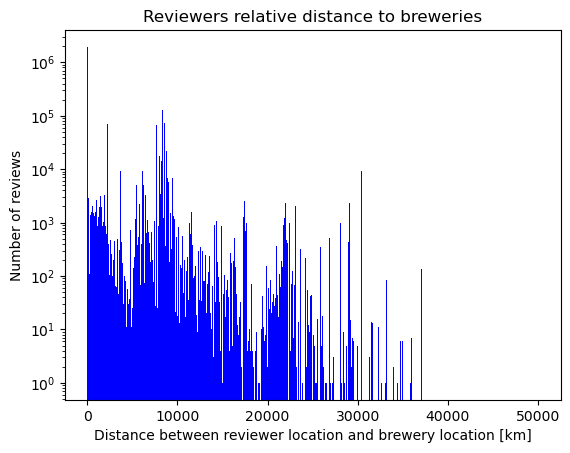

In [41]:
# Plot a histogram of the distances between reviewer and brewery locations
plt.hist(rev_distance['distance_country'], bins=np.linspace(0, 50000, 500), log=True, color='Blue')

# Set x and y labels and the title
plt.xlabel('Distance between reviewer location and brewery location [km]')
plt.ylabel('Number of reviews')
plt.title('Reviewers relative distance to breweries')

# Display the plot
plt.show()

The graph showing the distribution of relative distances between reviewers and breweries for each review is quite diversified, with a large proportion of reviews between 0 and 10,000km, corresponding in notably to intra-USA reviews. Although this graph allows us to better visualize this distribution of relative distances, it should be noted that some distances exceeding 25'000km seem inconsistent and that it will be necessary in the future to correct this by potentially switching to GPS coordinates instead of the actual projection.

### **Comparison of Relative Distance with Size and Popularity Metrics**

It's now interesting to look at the relative distance of reviewers for a given brewery based on its **popularity** and **size** metrics. This investigation would make it possible to discern whether a small local brewery receives a majority of reviews from nearby users, or whether a world-renowned brewery receives international reviews, resulting in a higher average distance.

First of all, we need to populate the distance dataframe with information on brewery popularity and size.

In [42]:
# Merge distance and metrics dataframes on 'brewery_id'
metric_distance = pd.merge(rev_distance[['brewery_id', 'distance_country', 'distance_state']],
                          df_metrics[['brewery_id', 'size_metrics', 'popularity_metrics']],
                          on=['brewery_id'], how='inner')

# Group by 'brewery_id' and calculate the median
metric_distance = metric_distance.groupby('brewery_id').median()

display(metric_distance)

,distance_country,distance_state,size_metrics,popularity_metrics
brewery_id,,,,
1,8867.127691,8164.275682,0.032004,0.034998
2,0.000000,0.000000,0.002639,0.002304
3,0.000000,2305.311260,0.160848,0.026699
4,0.000000,1800.258216,0.216354,0.038244
5,0.000000,4026.969769,0.015318,0.021744
...,...,...,...,...
49795,16382.753507,18430.973034,0.000485,0.000104
49796,0.000000,0.000000,0.000557,0.000346
49803,324.840255,324.840255,0.000249,0.000518


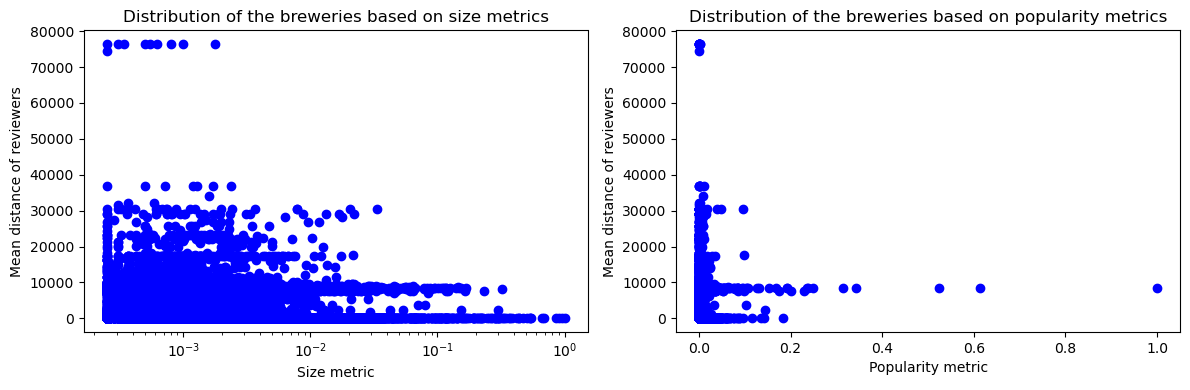

In [43]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot scatter for 'size metrics' in the first subplot
axs[0].scatter(metric_distance['size_metrics'], metric_distance['distance_country'], color='Blue')
axs[0].set_title('Distribution of the breweries based on size metrics')
axs[0].set_ylabel('Mean distance of reviewers')
axs[0].set_xlabel('Size metric')

# Plot histogram for 'popularity metrics' in the second subplot
axs[1].scatter(metric_distance['popularity_metrics'], metric_distance['distance_country'], color='Blue')
axs[1].set_title('Distribution of the breweries based on popularity metrics')
axs[1].set_ylabel('Mean distance of reviewers')
axs[1].set_xlabel('Popularity metric')

axs[0].set_xscale('log')
# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()

The graph above shows once again that the distribution of the average distance of reviews collected by breweries according to their size and popularity metrics is quite diverse. We see a majority of distances between 0 and 10'000km for a wide spectrum in terms of size metrics, and some seemingly inconsistent average distances (over 25'000km) which will have to be corrected later.

With regard to the popularity index, an interesting observation is the line that seems to form around the average review distance of 10'000km and concerns popular breweries. In fact, this distance corresponds to the distance USA - Europe and would indicate that the most popular breweries located mainly in Europe are highly rated by the overwhelming majority of US reviewers.

### **Merge reviews with Users dataframe**

For the following analysis a merge of the reviews, the users and the breweries filtered dataframe has to be done.

In [44]:
reviews_aug = pd.merge(reviews_filt, users_loc, on=['user_id','user_name'], how='inner')
display(reviews_aug)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_ratings,nbr_reviews,joined,user_location,user_state
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head....",1010,1010,2008-01-08 11:00:00,United States of America,Virginia
1,Double Bastard Ale,1056,Arrogant Brewing,43153,American Strong Ale,2008-05-22 10:00:00,Proteus93,proteus93.185128,4.5,4.5,5.0,4.5,4.5,4.55,A: Poured into a standard Stone pintglass. A d...,1010,1010,2008-01-08 11:00:00,United States of America,Virginia
2,OAKED Arrogant Bastard Ale,8951,Arrogant Brewing,43153,American Strong Ale,2008-01-26 11:00:00,Proteus93,proteus93.185128,5.0,4.0,4.5,4.5,4.5,4.41,"A: A deep brown pour, some red highlights. Bea...",1010,1010,2008-01-08 11:00:00,United States of America,Virginia
3,Trader Joe's 2012 Vintage Ale,86743,Trader Joe's Brewing Company,10707,Belgian Strong Dark Ale,2012-11-17 11:00:00,Proteus93,proteus93.185128,4.0,4.0,4.0,3.5,3.5,3.70,So we just had a Trader Joe's open up in Charl...,1010,1010,2008-01-08 11:00:00,United States of America,Virginia
4,Le Merle,37112,North Coast Brewing Co.,112,Saison / Farmhouse Ale,2009-01-19 11:00:00,Proteus93,proteus93.185128,4.0,3.5,4.5,4.0,4.0,3.93,"Served on tap at Beer Run in Charlottesville, ...",1010,1010,2008-01-08 11:00:00,United States of America,Virginia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492398,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-06-02 10:00:00,GWEBB9,gwebb9.166159,4.5,5.0,5.0,4.5,5.0,4.77,This is a great beer. Always go back to this o...,1,1,2007-10-20 10:00:00,United States of America,Maryland
2492399,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-04-16 10:00:00,norsktorsk,norsktorsk.319436,4.0,5.0,4.0,4.5,4.5,4.54,Its the start of the Stanley Cup Playoffs an I...,2,1,2009-04-13 10:00:00,United States of America,New York
2492400,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-03-04 11:00:00,benjilek,benjilek.300077,4.5,3.5,4.5,4.0,4.0,3.96,This was an exceptional beer. Very unique. It ...,1,1,2009-02-18 11:00:00,United States of America,Maryland
2492401,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-12-21 11:00:00,DunDun,dundun.272883,5.0,4.5,4.5,5.0,5.0,4.83,This is my first review and I just had to say ...,1,1,2008-12-02 11:00:00,United States of America,Ohio


### **Merge Reviews and Users with breweries dataframe**

In [45]:
df_RBU = pd.merge(reviews_aug, breweries_loc, on=['brewery_id','brewery_name'], how='inner')
display(df_RBU)
print('Number of NaN by category:')
print(df_RBU.isna().sum())

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,...,rating,text,nbr_ratings,nbr_reviews,joined,user_location,user_state,brewery_location,nbr_beers,brewery_state
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,...,4.37,"A: A deep amber, with a bit of a shorter head....",1010,1010,2008-01-08 11:00:00,United States of America,Virginia,United States of America,41,California
1,Double Bastard Ale,1056,Arrogant Brewing,43153,American Strong Ale,2008-05-22 10:00:00,Proteus93,proteus93.185128,4.5,4.5,...,4.55,A: Poured into a standard Stone pintglass. A d...,1010,1010,2008-01-08 11:00:00,United States of America,Virginia,United States of America,41,California
2,OAKED Arrogant Bastard Ale,8951,Arrogant Brewing,43153,American Strong Ale,2008-01-26 11:00:00,Proteus93,proteus93.185128,5.0,4.0,...,4.41,"A: A deep brown pour, some red highlights. Bea...",1010,1010,2008-01-08 11:00:00,United States of America,Virginia,United States of America,41,California
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,...,3.40,Poured this into a Bordeaux wine glass.A - A p...,47,47,2005-08-23 10:00:00,United States of America,New York,United States of America,41,California
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,...,4.32,A - Poured a dark amber color with an of white...,1409,1256,2007-09-21 10:00:00,United States of America,New York,United States of America,41,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341753,La Porteña Stout,273430,La Porteña Cervecería Artesanal,48642,American Stout,2017-03-23 11:00:00,Short_And_Stout,short_and_stout.1194173,4.0,3.5,...,3.76,"Look: dark brown, hints of red when held up to...",1,1,2017-03-15 11:00:00,United States of America,Pennsylvania,Nicaragua,1,Nicaragua
2341754,Public Static Lemongrass IPA,156860,Nerdbrewing,38748,American IPA,2015-02-08 11:00:00,kazin,kazin.236728,3.75,4.5,...,4.36,Sampled from bottle. Very cloudy appearance bu...,23,6,2008-07-23 10:00:00,Sweden,Sweden,Sweden,4,Sweden
2341755,R34 Porter,131988,Kozy Yak Brewery,33346,American Porter,2014-08-03 10:00:00,WalterDragon,walterdragon.838867,3.0,2.0,...,1.51,"Thought I would try a small, local brew pub. T...",16,2,2014-08-03 10:00:00,United States of America,Wisconsin,United States of America,9,Wisconsin
2341756,Can't Hook Kolsch,258870,Sawmill Brewing Company,44767,Kölsch,2017-02-27 11:00:00,Gully13,gully13.1192412,4.25,4.5,...,4.69,Poured from a growlerOverall a great take on t...,4,3,2017-02-27 11:00:00,United States of America,North Carolina,United States of America,11,Wisconsin


Number of NaN by category:
beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
date                0
user_name           0
user_id             0
appearance          0
aroma               0
palate              0
taste               0
overall             0
rating              0
text                0
nbr_ratings         0
nbr_reviews         0
joined              0
user_location       0
user_state          0
brewery_location    0
nbr_beers           0
brewery_state       0
dtype: int64


### **Temporal Analysis on ratings and the number of reviews**

With existing overview of the dataset, the next step is to investigate the temporal evolution of the beer market from the perspective of user ratings and reviews. Aligned with our interest in how brewery sizes matter, we pay specific attention to **how the ratings and reviews are distributed among breweries**.

In [46]:
# Take a subset columns of the dataframe and rename columns for clarification
merged = df_RBU[['brewery_name', 'brewery_id', 'date','rating', 'text', 'nbr_ratings', 'nbr_reviews', 'joined']].copy()

merged.rename(columns={'nbr_ratings': 'nbr_ratings_user',
                       'nbr_reviews': 'nbr_reviews_user',
                       'date': 'date_review',
                       'joined': 'joined_user'
                      }, inplace=True)

# Extract year from the datetime
# date_format = '%Y-%m-%d %H:%M:%S'
merged['joined_user_year'] = merged.joined_user.apply(lambda x: x.year)
merged['date_review_year'] = merged.date_review.apply(lambda x: x.year)

# merge by the [year, brewery]
merged_brewery_year = merged.groupby(['date_review_year','brewery_id']).apply(lambda x: pd.Series({
    'brewery_nbr_reviews': x.size,
    'brewery_avg_rating': x.rating.mean(),
    'brewery_rating_list': x.rating.tolist()
})).reset_index()

print('Data for each brewery per year')
merged_brewery_year.head()

Data for each brewery per year


,date_review_year,brewery_id,brewery_nbr_reviews,brewery_avg_rating,brewery_rating_list
0,1996,33,10,3.850000,[3.85]
1,1998,5,30,3.530000,"[4.2, 2.77, 3.62]"
2,1998,9,10,4.480000,[4.48]
3,1998,11,110,4.077273,"[3.85, 4.3, 4.35, 4.1, 4.17, 4.67, 3.82, 3.78,..."
4,1998,13,30,4.210000,"[4.37, 4.18, 4.08]"


In [47]:
# merge by the year of ratings for all breweries, preserving both macro (for breweries) and micro (equally treating reviews) info
'''
For each year::
nbr_reviews: #reviews received for all breweries
brewery_nbr_reviews: a list of #reviews for each brewery 
macro_avg_brewery_rating: the macro average rating of each brewery
brewery_avg_rating_list: the list of each brewery's average rating
ratings: all received rating scores
'''
merged_year = merged_brewery_year.groupby(['date_review_year']).apply(lambda x: pd.Series({
    'nbr_reviews': x.brewery_nbr_reviews.sum(),
    'brewery_nbr_reviews': x.brewery_nbr_reviews.tolist(),
    'macro_avg_brewery_rating': x.brewery_avg_rating.mean(),
    'brewery_avg_rating_list': x.brewery_avg_rating.tolist(),
    'ratings': x.brewery_rating_list.sum()
})).reset_index()

merged_year['micro_avg_rating'] = merged_year.ratings.agg(lambda x: np.mean(x))
print('Data for all breweries per year')
merged_year.head()

Data for all breweries per year


,date_review_year,nbr_reviews,brewery_nbr_reviews,macro_avg_brewery_rating,brewery_avg_rating_list,ratings,micro_avg_rating
0,1996,10,[10],3.850000,[3.85],[3.85],3.850000
1,1998,1090,"[30, 10, 110, 30, 10, 10, 20, 10, 20, 20, 10, ...",3.794912,"[3.53, 4.48, 4.077272727272727, 4.21, 3.45, 3....","[4.2, 2.77, 3.62, 4.48, 3.85, 4.3, 4.35, 4.1, ...",3.825963
2,1999,570,"[10, 10, 40, 110, 60, 10, 10, 30, 40, 10, 10, ...",3.722340,"[3.32, 3.88, 4.0675, 4.048181818181818, 4.0066...","[3.32, 3.88, 3.4, 4.2, 4.29, 4.38, 3.9, 3.45, ...",3.887544
3,2000,940,"[10, 90, 10, 10, 10, 10, 20, 10, 10, 20, 10, 1...",4.035441,"[3.26, 4.16, 3.99, 4.8, 4.47, 4.0, 3.83, 3.8, ...","[3.26, 4.35, 3.97, 3.79, 4.42, 4.17, 4.27, 4.0...",4.050638
4,2001,11080,"[30, 20, 30, 10, 70, 50, 60, 10, 50, 110, 20, ...",3.807379,"[4.433333333333334, 4.08, 3.8866666666666667, ...","[3.7, 4.76, 4.84, 4.1, 4.06, 4.06, 4.94, 2.66,...",3.845623


In [48]:
# statistics for visualization
stats_by_year = pd.DataFrame({
    'year': merged_year.date_review_year,
        'macro_average': merged_year.macro_avg_brewery_rating,
        'macro_std': merged_year.brewery_avg_rating_list.apply(lambda x: np.std(x)),
        'micro_average': merged_year.micro_avg_rating,
        'micro_std': merged_year.ratings.apply(lambda x: np.std(x)),
        'nbr_reviews': merged_year.nbr_reviews,
        'average_nbr_reviews': merged_year.brewery_nbr_reviews.apply(lambda x: np.mean(x)),
        'nbr_reviews_std': merged_year.brewery_nbr_reviews.apply(lambda x: np.std(x)),
        'nbr_reviews_percentage': merged_year[['nbr_reviews','brewery_nbr_reviews']].apply(lambda x: [y / x['nbr_reviews'] for y in x['brewery_nbr_reviews']], axis=1)
})
stats_by_year['percentage_mean'] = stats_by_year.nbr_reviews_percentage.apply(lambda x: np.mean(x))
stats_by_year['percentage_median'] = stats_by_year.nbr_reviews_percentage.apply(lambda x: np.median(x))
stats_by_year['percentage_std'] = stats_by_year.nbr_reviews_percentage.apply(lambda x: np.std(x))
stats_by_year['nbr_brewery'] = stats_by_year.nbr_reviews_percentage.apply(lambda x: len(x))

Text(0, 0.5, 'Ratings')

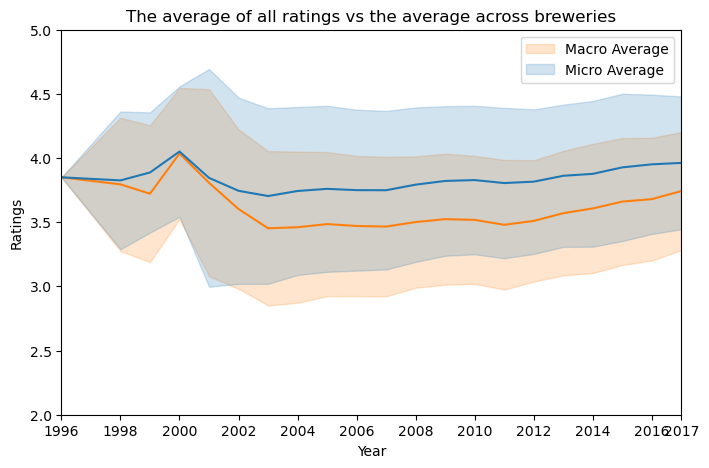

In [49]:
plt.figure(figsize=(8, 5), dpi=100)
plt.fill_between(stats_by_year.year, stats_by_year.macro_average - stats_by_year.macro_std,
                 stats_by_year.macro_average + stats_by_year.macro_std, alpha = 0.2, color = 'C1')
plt.plot(stats_by_year.year, stats_by_year.macro_average, color = 'C1', label='_nolegend_')
plt.fill_between(stats_by_year.year, stats_by_year.micro_average - stats_by_year.micro_std,
                 stats_by_year.micro_average + stats_by_year.micro_std, alpha = 0.2, color = 'C0')
line_micro = plt.plot(stats_by_year.year, stats_by_year.micro_average, color = 'C0', label='_nolegend_')

plt.ylim([2, 5])
plt.xlim([1996, 2017])
plt.xticks([1996,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016,2017])
plt.legend(['Macro Average','Micro Average'])
plt.title('The average of all ratings vs the average across breweries')
plt.xlabel('Year')
plt.ylabel('Ratings')

From the trend average of ratings, we observe that the micro average is generally higher than the macro average across the breweries. It indicates scenario such as: a few breweries receiving relatively higher amount of high ratigns. This motivates us to explore further the data with respect to different sizes of popularities of breweries.

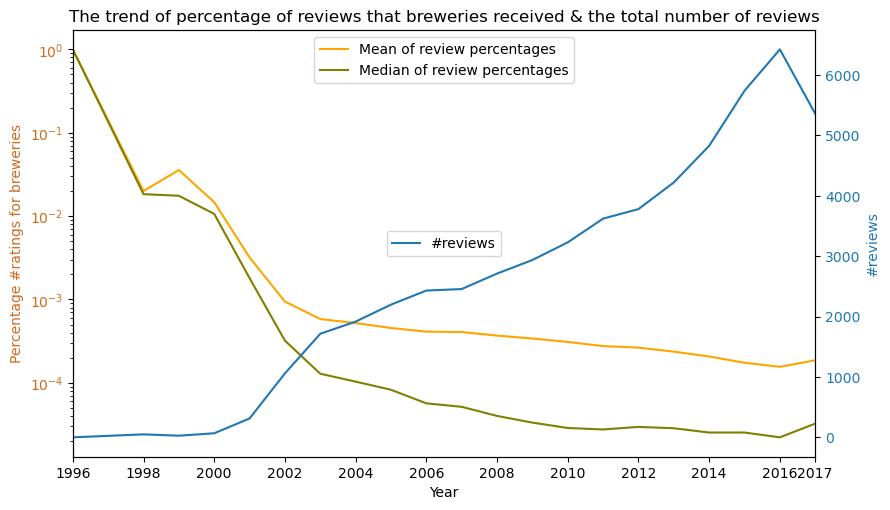

In [50]:
t = stats_by_year.year

fig, ax1 = plt.subplots(figsize=(9, 5), dpi=100)

# color = 'C1'
ax1.set_xlabel('Year')
ax1.set_xticks([1996,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016,2017])
ax1.set_yscale('log')
ax1.set_xlim([1996,2017])
ax1.set_ylabel('Percentage #ratings for breweries', color='chocolate')
ax1.plot(stats_by_year.year, stats_by_year.percentage_mean, color = 'orange')
ax1.plot(stats_by_year.year, stats_by_year.percentage_median, color = 'olive')
plt.legend(['Mean of review percentages','Median of review percentages'], loc = 'upper center')
# ax1.errorbar(stats_by_year.year, stats_by_year.percentage_mean,
#              yerr = stats_by_year.percentage_std,
#              capsize= 3, color = color)
ax1.tick_params(axis='y', labelcolor='chocolate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('#reviews', color=color2) 
ax2.set_xlim([1996,2017])
ax2.plot(stats_by_year.year, stats_by_year.nbr_brewery, color = color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.legend(['#reviews'], loc='center')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('The trend of percentage of reviews that breweries received & the total number of reviews')
plt.show()

The number of reviews is increasing along the years, possibly due to the development of internet and the brewing process. The divergence of mean and median of percentage of reviews received by breweries again indicate an unenvenly distribution across breweries。

From the decreasing curves of means and medians, we have two assumptions that should be validated later during mileston 3:
* The number of breweries competing in the beer market is growing
* In its early years, the BeerAdvocate website collected ratings for only a few breweries.


Text(0.5, 1.0, 'The distribution of percentage of reviews received by breweries')

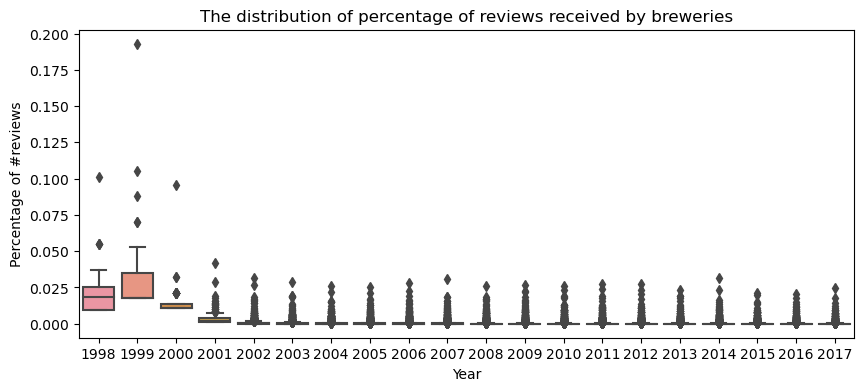

In [51]:
stats_by_year_long = stats_by_year[stats_by_year.year >= 1997][['year','nbr_reviews_percentage']].copy()
stats_by_year_long = stats_by_year_long.explode('nbr_reviews_percentage')
# df_long['grades'] = pd.to_numeric(df_long['grades'])
plt.figure(figsize=(10, 4), dpi=100)
ax = sns.boxplot(data=stats_by_year_long, x='year', y='nbr_reviews_percentage')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of #reviews')
ax.set_title('The distribution of percentage of reviews received by breweries')

From the boxplot, it is interesting to observe massive number outliers with percentage of reviews higher than average, especially after the year of 2000. The boxplot indicates that while the mojority of breweries receive nearly zero reviews on BeerAdvocate website, there are a few breweries receiving much higher number of reviews. Therefore, we research question regarding this phenomenon is: 

**Does monopoly power dominates the beer industry? If yes, do those monopoly share common sizes and popularities?** 